In [1]:
from torch_geometric.datasets import MoleculeNet
import torch
import numpy as np

## Import Dataset

In [2]:
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math

class FingerprintDataset(Dataset):
    def __init__(self,split):
        # Initialize data, download, etc.
        # read with numpy or pandas
        xy = np.loadtxt(f'./fingerprints/bace_fingerprints_reg_ale_{split}.csv', delimiter=',', dtype=np.float32, skiprows=1)

        self.x = torch.from_numpy(xy[:,1:])
        self.y = torch.from_numpy(xy[:,[0]])
        self.n_samples = xy.shape[0]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [3]:
data = FingerprintDataset()

In [4]:
#Specify device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## Set Hyperparameters

In [5]:
import best_config

no_of_epochs = best_config.GLOBALPARAMETERS['no_of_epochs']
train_size = best_config.GLOBALPARAMETERS['train_size']
valid_size = best_config.GLOBALPARAMETERS['valid_size']

In [6]:
#Get Model Parameters
hyperparameters = eval('best_config.'+best_config.GLOBALPARAMETERS['model_this_run']+'_HYPERPARAMETERS')

model_params = hyperparameters
model_params['feature_size'] = data.x.shape[1]

## Define Model

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
model_params

{'has_edge_info': False,
 'batch_size': 16,
 'learning_rate': 0.0002007339899573065,
 'model_layers': 2,
 'model_embedding_size': 256,
 'model_dense_neurons': 256,
 'model_linear_dropout_rate': 0.052950804012409605,
 'model_embedding_dropout_rate': 0.1591852948412082,
 'feature_size': 1016}

In [21]:
import models
print("Loading model...")

#Create instance of model
model = eval('models.'+best_config.GLOBALPARAMETERS['model_this_run']+'(model_params)')
print(model)
print(count_parameters(model))

Loading model...
MLP_REGRESSION(
  (conv_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
  )
  (bn_layers): ModuleList(
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (initial_conv): Linear(in_features=1016, out_features=256, bias=True)
  (embedding_dropout): Dropout(p=0.1591852948412082, inplace=False)
  (linear_dropout): Dropout(p=0.052950804012409605, inplace=False)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
)
392705


In [22]:
model = model.to(device)

In [11]:
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.007)  

train = int(train_size * len(data))
valid = int(valid_size * len(data))
test = len(data) - train - valid
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(data, [train, valid, test])

NUM_FINGERPRINTS_PER_BATCH = model_params['batch_size']
train_loader = DataLoader(train_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)

## Training Loop

In [12]:
class Engine:
    def __init__(self, model, model_params, optimizer, device):
        self.model = model
        self.model_params = model_params
        self.optimizer = optimizer
        self.device = device
        self.loss_fn = torch.nn.MSELoss()

    def train(self, loader):
        self.model.train()
        # Enumerate over the data
        final_loss = 0
        for i, (fingerprint, labels) in enumerate(loader):
            self.optimizer.zero_grad()  
            fingerprint = fingerprint.to(self.device)
            labels = labels.to(self.device)
            # Forward pass
            outputs = self.model(fingerprint)
            loss = self.loss_fn(outputs, labels)
            # Backward and optimize
            final_loss += loss.item()
            loss.backward()
            self.optimizer.step() 
        return final_loss / len(loader)
    
    def evaluate(self, loader):
            self.model.eval()
            # Enumerate over the data
            final_loss = 0
            for i, (fingerprint, labels) in enumerate(loader):  
                fingerprint = fingerprint.to(self.device)
                labels = labels.to(self.device)
                # Forward pass
                outputs = self.model(fingerprint)
                loss = self.loss_fn(outputs, labels)
                final_loss += loss.item()
            return final_loss / len(loader)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=model_params['learning_rate'])  

eng = Engine(model, model_params, optimizer, device)

print("Starting training...")
losses = []
for epoch in range(no_of_epochs):
    loss = eng.train(train_loader)
    val_loss = eng.evaluate(valid_loader)
    losses.append(loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss {loss} | Valid Loss {val_loss}")

Starting training...
Epoch 0 | Train Loss 39.24533738761112 | Valid Loss 22.291720817829
Epoch 10 | Train Loss 0.33278132307118385 | Valid Loss 0.6388765481011621
Epoch 20 | Train Loss 0.1599465400494378 | Valid Loss 0.7147385873671236
Epoch 30 | Train Loss 0.13122887421270896 | Valid Loss 0.7150231445657795
Epoch 40 | Train Loss 0.10382089339967432 | Valid Loss 0.7287509837027254
Epoch 50 | Train Loss 0.10457871655194924 | Valid Loss 0.7549272220710228
Epoch 60 | Train Loss 0.11774768641796605 | Valid Loss 0.7831422737960158
Epoch 70 | Train Loss 0.10718968433552775 | Valid Loss 0.7789111455966686
Epoch 80 | Train Loss 0.08746786685339336 | Valid Loss 0.7536397504395452
Epoch 90 | Train Loss 0.1095028362911323 | Valid Loss 0.7707150074942358
Epoch 100 | Train Loss 0.09162365876395127 | Valid Loss 0.7277672966492588
Epoch 110 | Train Loss 0.07901122819246917 | Valid Loss 0.7390290231540285
Epoch 120 | Train Loss 0.09550573265758054 | Valid Loss 0.7739702493980013
Epoch 130 | Train Loss

## Evaluate on the Test Set

In [24]:
import pandas as pd 
model.eval()
true_values = []
predictions = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for fingerprint, labels in test_loader:
        fingerprint = fingerprint.to(device)
        labels = labels.to(device)
        output = model(fingerprint)
        true_values += labels.tolist()
        predictions += output.tolist()
df = pd.DataFrame({'y_pred':predictions,'y_real':true_values})
df = df.applymap(lambda x : x[0])
df

,y_pred,y_real
0,4.940637,4.517127
1,7.685897,7.283997
2,7.508466,8.508638
3,6.024779,6.200659
4,4.669238,4.273273
...,...,...
602,4.404504,6.089910
603,6.887865,7.216096
604,6.636211,6.838632
605,3.511655,4.721246


## Model Evaluation

In [25]:
from sklearn import metrics

In [26]:
mse = metrics.mean_squared_error(df["y_real"],df["y_pred"])
mae = metrics.mean_absolute_error(df["y_real"],df["y_pred"])
r = metrics.r2_score(df["y_real"],df["y_pred"])

print(mse, mae, r)

0.7310768272508715 0.6659203266979639 0.6051962904620835


<AxesSubplot:xlabel='y_pred', ylabel='y_real'>

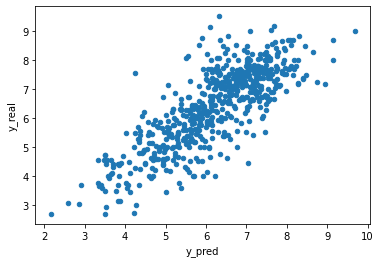

In [27]:
df.plot.scatter(x='y_pred',y='y_real')

In [28]:
rho = np.corrcoef(df['y_real'],df['y_pred'])[0,1]
rho

0.801521830980872

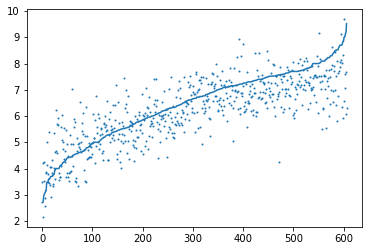

In [29]:
import matplotlib.pyplot as plt

sorted_data = df.sort_values('y_real')

index = [i for i in range(len(df))]
plt.plot(index, sorted_data['y_real'])
plt.scatter(index, sorted_data['y_pred'], s=1)